# Importação de Bibliotecas

In [1]:
import torch
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

from sklearn import datasets
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

# Definição de funções

## Modelos

In [2]:
class MLP(torch.nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        batch_size = 8,
        lr = 0.01,
        device = 'cpu',
        random_state = None,
    ):
        super(MLP, self).__init__()

        # Definir os parâmetros da rede
        self.__hidden_size = 1
        self.__input_size = input_size
        self.__output_size = output_size
        self.__lr = lr
        self.__batch_size = batch_size
        self.__device = device
        self.__random_state = random_state

        # Definir o random state
        if self.__random_state != None:
            torch.manual_seed(self.__random_state)
            if self.__device == 'cuda':
                torch.cuda.manual_seed(self.__random_state)
                torch.cuda.manual_seed_all(self.__random_state)

        self.__in = torch.nn.ModuleList([torch.nn.Linear(self.__input_size, 1)])
        self.__hidden = torch.nn.ModuleList([torch.nn.Linear(1, 1)])
        self.__out = torch.nn.Linear(1, self.__output_size)

        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=self.__lr)

        self.losses = []

    def forward(self, x):
        # define a saída da camada escondida
        x_hidden = []
        for in_layer, hidden_layer in zip(self.__in, self.__hidden):
            x_hidden_tensor = in_layer(x)
            x_hidden_tensor = nn.functional.relu(x_hidden_tensor)
            x_hidden_tensor = hidden_layer(x_hidden_tensor)
            x_hidden.append(x_hidden_tensor)

        # Converte para tensor
        x_hidden_tensor = torch.cat(x_hidden, dim = 1)
        x = self.__out(x_hidden_tensor)
        return x

    def get_hidden_output(self, x):
        # Definir o random state
        if self.__random_state != None:
            torch.manual_seed(self.__random_state)
            if self.__device == 'cuda':
                torch.cuda.manual_seed(self.__random_state)
                torch.cuda.manual_seed_all(self.__random_state)
                np.random.seed(self.__random_state)

        # Converter para tensor e garantir a dimensão correta
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)

        model = self.to(self.__device)

        # Prever com o modelo treinado
        model.eval()  # Modo de avaliação
        with torch.no_grad():  # Desativar gradientes
          # define a saída da camada escondida
          x_hidden = []
          for in_layer, hidden_layer in zip(self.__in, self.__hidden):
              x_hidden_tensor = in_layer(x)
              x_hidden_tensor = nn.functional.relu(x_hidden_tensor)
              x_hidden_tensor = hidden_layer(x_hidden_tensor)
              x_hidden.append(x_hidden_tensor)

          # Converte para tensor
          x_hidden_tensor = torch.cat(x_hidden, dim = 1)
          x = x_hidden_tensor

        # A previsão é um tensor, vamos converter para numpy
        return x.detach().numpy()

    def add_hidden_neuron(self):
        # Congelar os pesos da camada de entrada e intermediária
        self.__in[-1].weight.requires_grad = False
        self.__in[-1].bias.requires_grad = False
        self.__hidden[-1].weight.requires_grad = False
        self.__hidden[-1].bias.requires_grad = False

        # Adicionar um novo neurônio a camada intermediária
        self.__in.append(torch.nn.Linear(self.__input_size, 1))
        self.__hidden.append(torch.nn.Linear(1, 1))
        self.__hidden_size += 1

        # Alterar a dimensão da camada de saída
        out_layer = torch.nn.Linear(self.__hidden_size, self.__output_size)
        with torch.no_grad():
            out_layer.weight[:, :-1] = self.__out.weight
            out_layer.bias = self.__out.bias
        self.__out = out_layer

    def fit(self, data, target, n_epochs):
        # Definir o random state
        if self.__random_state != None:
            torch.manual_seed(self.__random_state)
            if self.__device == 'cuda':
                torch.cuda.manual_seed(self.__random_state)
                torch.cuda.manual_seed_all(self.__random_state)
                np.random.seed(self.__random_state)

        # Converter os dados em tensores
        inputs = torch.stack(
            [torch.from_numpy(np.array(item).astype(np.float32)) for item in data]
        )
        labels = torch.stack(
            [torch.from_numpy(np.array(item).astype(np.float32)) for item in target]
        )

        # Criar um DataLoader
        dataset = torch.utils.data.TensorDataset(inputs, labels)
        train_data = torch.utils.data.DataLoader(
            dataset, batch_size=self.__batch_size, shuffle=True
        )

        model = self.to(self.__device)

        # Loop de treinamento
        with tqdm(total=n_epochs, desc=f"Epoch") as pbar:
            for _ in range(n_epochs):
                total_loss = 0.0
                for data, target in train_data:
                    # Zerar gradientes
                    self.optimizer.zero_grad()
                    
                    # Fazer predição
                    predictions = model(data.to(self.__device))
                    
                    # Calcular a perda
                    loss = self.criterion(predictions, target.to(self.__device))
                    
                    # Backpropagation e atualização do otimizador
                    loss.backward()
                    self.optimizer.step()
                    total_loss += loss.item()
                
                self.losses.append(total_loss)
                pbar.update(1)
                pbar.set_postfix(loss=total_loss)

    def predict(self, data):
        # Definir o random state
        if self.__random_state != None:
            torch.manual_seed(self.__random_state)
            if self.__device == 'cuda':
                torch.cuda.manual_seed(self.__random_state)
                torch.cuda.manual_seed_all(self.__random_state)
                np.random.seed(self.__random_state)

        # Converter para tensor e garantir a dimensão correta
        data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)

        model = self.to(self.__device)

        # Prever com o modelo treinado
        model.eval()  # Modo de avaliação
        with torch.no_grad():  # Desativar gradientes
            prediction = model.forward(data.to(self.__device))  # Fazer a previsão

        # A previsão é um tensor, vamos converter para numpy
        return prediction.detach().numpy()

    def get_in_layer_weights(self):
        weights = []
        for in_layer in self.__in:
            weights.append(in_layer.weight.detach().numpy())
        return np.concatenate(weights, axis=0)

    def get_hidden_layer_weights(self):
        weights = []
        for hidden_layer in self.__hidden:
            weights.append(hidden_layer.weight.detach().numpy())
        return np.concatenate(weights, axis=0)

In [3]:
class PCD(MLP):
  def __init__(
        self,
        input_size,
        output_size,
        batch_size = 8,
        lr = 0.01,
        device = 'cpu',
        random_state = None,
    ):
      super(PCD, self).__init__(
        input_size,
        output_size,
        batch_size,
        lr,
        device,
        random_state,
    )

  def transform(self, data):
      transform_f = []
      for d in data:
        transform_f.append(self.get_hidden_output(d).copy())
      return np.vstack(transform_f)

  def fit_transform(self, data, target, n_components, n_epochs):
    for _ in range(n_components):
      self.fit(data, target, n_epochs//n_components)
      if _ != n_components - 1:
        self.add_hidden_neuron()
    return self.transform(data)

# Exemplo 1: Conjunto Iris

## Lendo o dataset

In [4]:
iris = datasets.load_iris()
data_iris = iris.data  # Dados (4 dimensões)
target_iris = iris.target  # Classes (3 classes: 0, 1, 2)
target_names = iris.target_names  # Nomes das classes ('setosa', 'versicolor', 'virginica')
feature_names = iris.feature_names

df = pd.DataFrame(data_iris, columns=iris.feature_names)
df['species'] = pd.Series([iris.target_names[i] for i in target_iris])
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


## Plotando os gráficos

In [5]:
palette = {0: 'red', 1: 'green', 2: 'blue'}
colors = [palette[x] for x in target_iris]

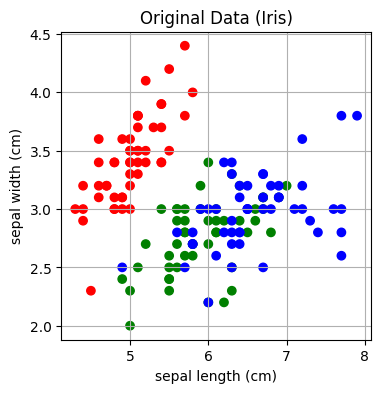

In [6]:
# Plotar as duas primeiras características do dataset original
plt.figure(figsize=(4, 4))

# Plot do dataset original (usando as duas primeiras características)
plt.scatter(df['sepal length (cm)'], df['sepal width (cm)'], c=colors)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.title('Original Data (Iris)')
plt.grid(True)
plt.show()

## PCA

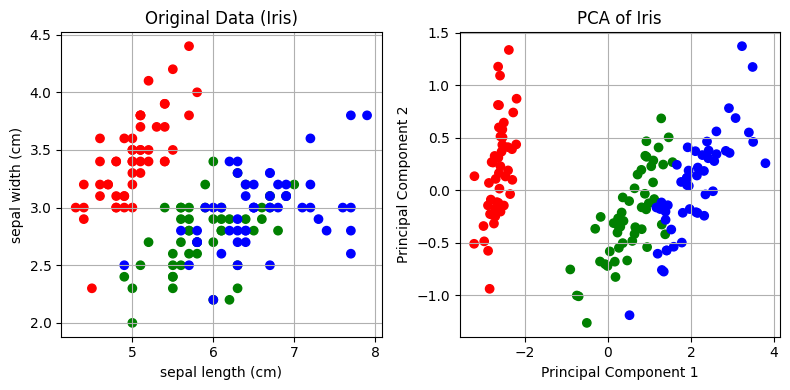

In [7]:
# Aplicar PCA para redução para duas dimensões
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_iris)

plt.figure(figsize=(8, 4))

# Plot do dataset original (usando as duas primeiras características)
plt.subplot(1, 2, 1)
plt.scatter(df['sepal length (cm)'], df['sepal width (cm)'], c=colors)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.title('Original Data (Iris)')
plt.grid(True)

# Plot PCA
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Iris')
plt.grid(True)

plt.tight_layout()


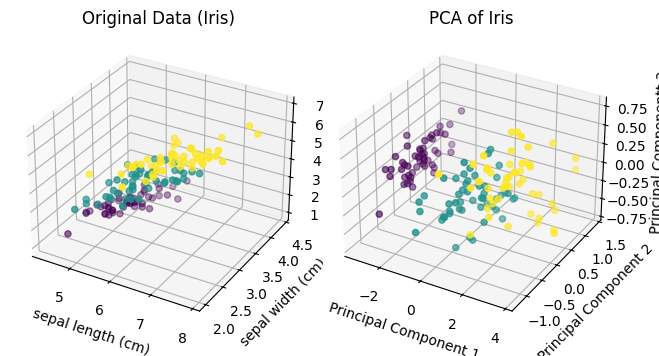

In [8]:
# Aplicar LDA para redução para três dimensões
lda = PCA(n_components=3)
X_lda = lda.fit_transform(data_iris, target_iris)

# Criar gráfico 3D do dataset original (usando as três primeiras características)
fig = plt.figure()

# Gráfico do dataset original
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(df[feature_names[0]], df[feature_names[1]], df[feature_names[2]], c=target_iris, cmap='viridis')
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.set_zlabel(feature_names[2])
ax1.set_title("Original Data (Iris)")
ax1.grid(True)

# Gráfico do LDA em 3D
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_lda[:, 0], X_lda[:, 1], X_lda[:, 2], c=target_iris, cmap='viridis')
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 2")
ax2.set_zlabel("Principal Componentt 3")
ax2.set_title("PCA of Iris")
ax2.grid(True)

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Exibir gráficos
plt.show()


In [9]:
for n_components in range(1,5):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(data_iris)

    # Aplicar one-hot encoding ao target
    onehot_encoder = OneHotEncoder(sparse=False)
    target_iris_onehot = onehot_encoder.fit_transform(target_iris.reshape(-1, 1))

    # Dividir o conjunto de dados em treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X_pca, target_iris_onehot, test_size=0.3, random_state=42)

    # Normalizar os dados
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Instanciar a rede neural MLP com entrada de 4 dimensões e saída de 3 classes
    mlp = MLP(input_size=n_components, output_size=3, lr=0.01, random_state=0)

    # Treinar o modelo por 100 epochs
    mlp.fit(X_train, y_train, n_epochs=50)
    mlp.add_hidden_neuron()
    mlp.fit(X_train, y_train, n_epochs=25)

    y_pred = []
    for X in X_test:
        # Fazer previsões no conjunto de teste e verificar a acurácia
        y_pred_l = mlp.predict(X)
        y_pred.append(np.argmax(y_pred_l, axis=1))

    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    print(f'Components: {n_components}')
    print(f'Accuracy: {accuracy:.2f}')
    print('')

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Epoch: 100%|██████████| 25/25 [00:00<00:00, 139.99it/s, loss=3.1] 
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Components: 1
Accuracy: 0.29



Epoch: 100%|██████████| 25/25 [00:00<00:00, 144.15it/s, loss=3.11]
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Components: 2
Accuracy: 0.36



Epoch: 100%|██████████| 25/25 [00:00<00:00, 143.71it/s, loss=3.08]
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Components: 3
Accuracy: 0.31



Epoch: 100%|██████████| 25/25 [00:00<00:00, 143.70it/s, loss=3.15]


Components: 4
Accuracy: 0.36



## LDA

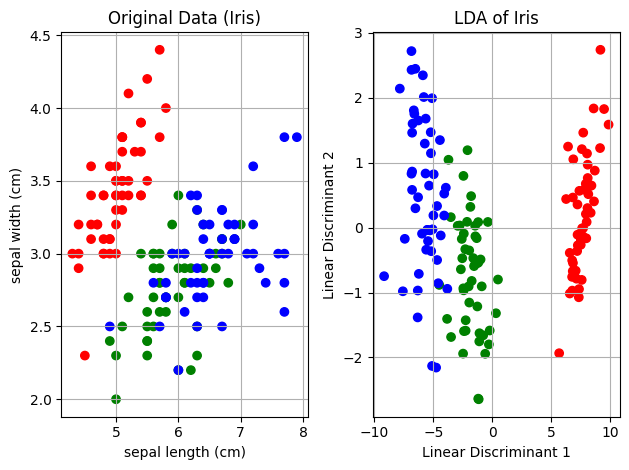

In [10]:
# Aplicar LDA para redução para duas dimensões
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(data_iris, target_iris)

# Plot do dataset original (usando as duas primeiras características)
plt.subplot(1, 2, 1)
plt.scatter(df['sepal length (cm)'], df['sepal width (cm)'], c=colors)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.title('Original Data (Iris)')
plt.grid(True)

# Plot LDA
plt.subplot(1, 2, 2)
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=colors)
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.title('LDA of Iris')
plt.grid(True)

plt.tight_layout()


In [11]:
for n_components in range(1, 3):
    # Aplicar LDA para redução para duas dimensões
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    X_lda = lda.fit_transform(data_iris, target_iris)

    # Aplicar one-hot encoding ao target
    onehot_encoder = OneHotEncoder(sparse=False)
    target_iris_onehot = onehot_encoder.fit_transform(target_iris.reshape(-1, 1))

    # Dividir o conjunto de dados em treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X_lda, target_iris_onehot, test_size=0.3, random_state=42)

    # Normalizar os dados
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Instanciar a rede neural MLP com entrada de 4 dimensões e saída de 3 classes
    mlp = MLP(input_size=n_components, output_size=3, lr=0.01, random_state=0)

    # Treinar o modelo por 100 epochs
    mlp.fit(X_train, y_train, n_epochs=25)
    mlp.add_hidden_neuron()
    mlp.fit(X_train, y_train, n_epochs=25)
    mlp.add_hidden_neuron()
    mlp.fit(X_train, y_train, n_epochs=25)
    mlp.add_hidden_neuron()
    mlp.fit(X_train, y_train, n_epochs=25)

    y_pred = []
    for X in X_test:
        # Fazer previsões no conjunto de teste e verificar a acurácia
        y_pred_l = mlp.predict(X)
        y_pred.append(np.argmax(y_pred_l, axis=1))

    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    print(f'Components: {n_components}')
    print(f'Accuracy: {accuracy:.2f}')
    print('')

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Epoch: 100%|██████████| 25/25 [00:00<00:00, 132.14it/s, loss=3.41]
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Components: 1
Accuracy: 0.67



Epoch: 100%|██████████| 25/25 [00:00<00:00, 131.93it/s, loss=2.89]


Components: 2
Accuracy: 0.51



## PCD

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Epoch: 100%|██████████| 50/50 [00:00<00:00, 109.95it/s, loss=2.56]


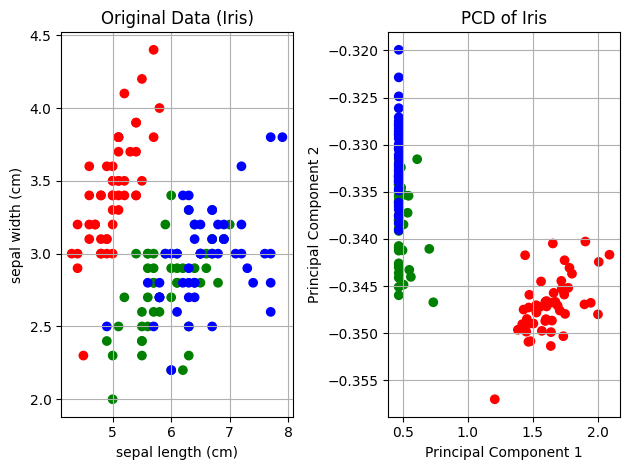

In [12]:
# Aplicar one-hot encoding ao target
onehot_encoder = OneHotEncoder(sparse=False)
target_iris_onehot = onehot_encoder.fit_transform(target_iris.reshape(-1, 1))

# Aplicar PCD para redução para duas dimensões
pcd = PCD(input_size = 4, output_size = 3,random_state = 123456)
X_pcd = pcd.fit_transform(data_iris, target_iris_onehot, 2, 100)

# Plot do dataset original (usando as duas primeiras características)
plt.subplot(1, 2, 1)
plt.scatter(df['sepal length (cm)'], df['sepal width (cm)'], c=colors)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.title('Original Data (Iris)')
plt.grid(True)

# Plot PCD
plt.subplot(1, 2, 2)
plt.scatter(X_pcd[:, 0], X_pcd[:, 1], c=colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCD of Iris')
plt.grid(True)

plt.tight_layout()

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Epoch: 100%|██████████| 33/33 [00:00<00:00, 104.75it/s, loss=3.49]


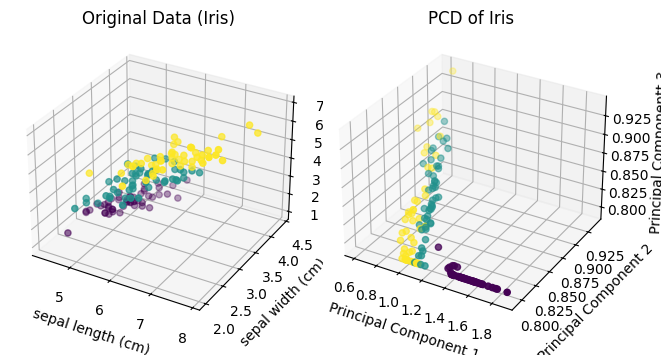

In [13]:
# Aplicar one-hot encoding ao target
onehot_encoder = OneHotEncoder(sparse=False)
target_iris_onehot = onehot_encoder.fit_transform(target_iris.reshape(-1, 1))

# Aplicar PCD para redução para duas dimensões
pcd = PCD(input_size = 4, output_size = 3,random_state = 123456)
X_pcd = pcd.fit_transform(data_iris, target_iris_onehot, 3, 100)

# Criar gráfico 3D do dataset original (usando as três primeiras características)
fig = plt.figure()

# Gráfico do dataset original
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(df[feature_names[0]], df[feature_names[1]], df[feature_names[2]], c=target_iris, cmap='viridis')
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.set_zlabel(feature_names[2])
ax1.set_title("Original Data (Iris)")
ax1.grid(True)

# Gráfico do LDA em 3D
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_pcd[:, 0], X_pcd[:, 1], X_pcd[:, 2], c=target_iris, cmap='viridis')
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 2")
ax2.set_zlabel("Principal Componentt 3")
ax2.set_title("PCD of Iris")
ax2.grid(True)

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Exibir gráficos
plt.show()


### Prevendo com o mesmo modelo

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Epoch: 100%|██████████| 25/25 [00:00<00:00, 136.95it/s, loss=2.59]


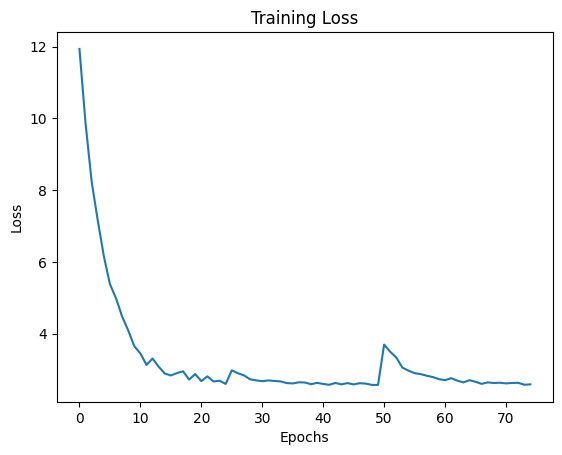

Accuracy: 0.71


In [14]:
# Aplicar one-hot encoding ao target
onehot_encoder = OneHotEncoder(sparse=False)
target_iris_onehot = onehot_encoder.fit_transform(target_iris.reshape(-1, 1))

# Dividir o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(data_iris, target_iris_onehot, test_size=0.3, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instanciar a rede neural MLP com entrada de 4 dimensões e saída de 3 classes
mlp = MLP(input_size=4, output_size=3, lr=0.01, random_state=0)

# Treinar o modelo por 100 epochs
mlp.fit(X_train, y_train, n_epochs=25)
mlp.add_hidden_neuron()
mlp.fit(X_train, y_train, n_epochs=25)
mlp.add_hidden_neuron()
mlp.fit(X_train, y_train, n_epochs=25)

# Plotar a curva de perda para ver o comportamento do treinamento
plt.plot(mlp.losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

y_pred = []
for X in X_test:
    # Fazer previsões no conjunto de teste e verificar a acurácia
    y_pred_l = mlp.predict(X)
    y_pred.append(np.argmax(y_pred_l, axis=1))

accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print(f'Accuracy: {accuracy:.2f}')

### Prevendo com outro modelo

In [15]:
# Aplicar one-hot encoding ao target
onehot_encoder = OneHotEncoder(sparse=False)
target_iris_onehot = onehot_encoder.fit_transform(target_iris.reshape(-1, 1))
for n_components in range(1, 10):

    # Aplicar PCD para redução para duas dimensões
    pcd = PCD(input_size = 4, output_size = 3, random_state = 123456)
    X_pcd = pcd.fit_transform(data_iris, target_iris_onehot, n_components, 100)

    # Dividir o conjunto de dados em treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X_pcd, target_iris_onehot, test_size=0.3, random_state=42)

    # Normalizar os dados
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Instanciar a rede neural MLP com entrada de 4 dimensões e saída de 3 classes
    mlp = MLP(input_size=n_components, output_size=3, lr=0.01, random_state=0)

    # Treinar o modelo por 100 epochs
    mlp.fit(X_train, y_train, n_epochs=25)
    mlp.add_hidden_neuron()
    mlp.fit(X_train, y_train, n_epochs=25)
    mlp.add_hidden_neuron()
    mlp.fit(X_train, y_train, n_epochs=25)
    mlp.add_hidden_neuron()
    mlp.fit(X_train, y_train, n_epochs=25)

    y_pred = []
    for X in X_test:
        # Fazer previsões no conjunto de teste e verificar a acurácia
        y_pred_l = mlp.predict(X)
        y_pred.append(np.argmax(y_pred_l, axis=1))

    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    print(f'Components: {n_components}')
    print(f'Accuracy: {accuracy:.2f}')
    print('')

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
Epoch: 100%|██████████| 25/25 [00:00<00:00, 131.49it/s, loss=3.36]


Components: 1
Accuracy: 0.71



Epoch: 100%|██████████| 25/25 [00:00<00:00, 131.39it/s, loss=3.07]


Components: 2
Accuracy: 0.33



Epoch: 100%|██████████| 25/25 [00:00<00:00, 128.18it/s, loss=2.25]


Components: 3
Accuracy: 0.71



Epoch: 100%|██████████| 25/25 [00:00<00:00, 130.06it/s, loss=3.12]


Components: 4
Accuracy: 0.29



Epoch: 100%|██████████| 25/25 [00:00<00:00, 131.86it/s, loss=3.16]


Components: 5
Accuracy: 0.40



Epoch: 100%|██████████| 25/25 [00:00<00:00, 132.29it/s, loss=1.73]


Components: 6
Accuracy: 0.67



Epoch: 100%|██████████| 25/25 [00:00<00:00, 131.74it/s, loss=3.07]


Components: 7
Accuracy: 0.40



Epoch: 100%|██████████| 25/25 [00:00<00:00, 132.14it/s, loss=3.38]


Components: 8
Accuracy: 0.13



Epoch: 100%|██████████| 25/25 [00:00<00:00, 132.52it/s, loss=3.22]


Components: 9
Accuracy: 0.18

